## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 70 kB 9.5 MB/s 
     |████████████████████████████████| 1.1 MB 53.2 MB/s 
     |████████████████████████████████| 288 kB 100.5 MB/s 
     |████████████████████████████████| 45 kB 3.9 MB/s 
     |████████████████████████████████| 112 kB 100.2 MB/s 
     |████████████████████████████████| 271 kB 96.8 MB/s 
     |████████████████████████████████| 144 kB 83.3 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 749 kB 72.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169803, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 1000 steps
Generated time-series
Normalized 'candles_norm' with shape : (1000, 9)
Feature data 'x_candles' with size : 952
Feature data with time intervals 'x_time' with size : 952


In [6]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

In [7]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

84

,Close,Pred Close
Date,,
2022-06-16 20:16:00,20966.25,21291.400219
2022-06-16 20:31:00,20561.56,21278.248366
2022-06-16 20:46:00,20712.58,21289.380634
2022-06-16 21:01:00,20761.05,21218.315455
2022-06-16 21:16:00,20850.52,21197.749728
...,...,...
2022-06-26 16:46:00,21352.02,21485.519348
2022-06-26 17:01:00,21318.58,21493.414388
2022-06-26 17:16:00,21204.33,21501.960801


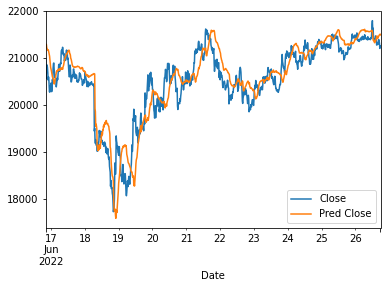

In [8]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

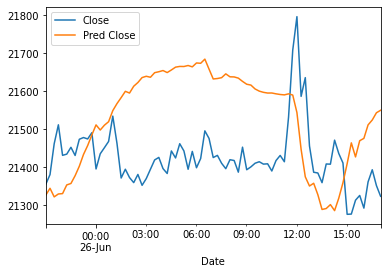

In [9]:
df_preds_true.dropna().iloc[-new_time_steps:].plot()

Fee: 0.025
----------------------
Buy      10 ( 7 ok 3 ko )
Avg PCT gain: 1.0019401233872118
Avg PCT loss: 0.9993284507349282
Wins  PCT   0.7
Avg PCT Gain.    1.0019401233872118
No-op    0
Wallet   235.51074999999958
Drawback -43.58300000000045
Kelly Fraction    0.4007819846489791
Total earned 235.51074999999958


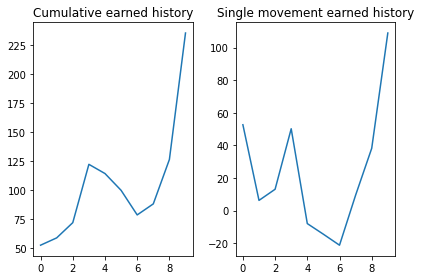

In [18]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-100:], ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)